In [45]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook


### HGNC Mapper

In [2]:
hgnc = pd.read_csv('../../data/hgnc_alias_list.txt', sep='\t')
hgnc.head()

hgnc = hgnc[hgnc['Approved symbol'].apply(lambda x: 'withdrawn' not in x)]

# get the original keys
hgnc_original_keys = hgnc['Approved symbol'].unique()

# drop a lot of columns for efficiency
hgnc = hgnc[list(hgnc.columns)[0:6]].drop('Status', axis=1)

# filter out Nan synonyms (not helpful)
hgnc_syn_list = hgnc[~ hgnc.Synonyms.isna()]
hgnc_prev_symb_list = hgnc[~ hgnc['Previous symbols'].isna()]

print(hgnc_syn_list.shape)
print(hgnc_syn_list.columns)
display(hgnc_syn_list.head())

print(hgnc_prev_symb_list.shape)
print(hgnc_prev_symb_list.columns)
display(hgnc_prev_symb_list.head())

#convert the synonyms column to a list
# convert these lists to pd.Series
# merge with original dataframe
#drop old synonyms column 
# melt the new columns into rows


current_syn_list = hgnc_syn_list.Synonyms.apply(lambda x: x.split(',')) \
    .apply(pd.Series) \
    .merge(hgnc, left_index = True, right_index = True) \
    .drop(["Synonyms"], axis = 1) \
    .melt(id_vars = ['HGNC ID', 'Approved symbol', 'Approved name', 'Previous symbols'], value_name = "synonym") 

current_syn_list = current_syn_list[~ current_syn_list.synonym.isna()]
current_syn_list.synonym = current_syn_list.synonym.apply(lambda x: x.replace(' ',''))

prev_symb_list = hgnc_prev_symb_list['Previous symbols'].apply(lambda x: x.split(',')) \
    .apply(pd.Series) \
    .merge(hgnc, left_index = True, right_index = True) \
    .drop(['Previous symbols'], axis = 1) \
    .melt(id_vars = ['HGNC ID', 'Approved symbol', 'Approved name', 'Synonyms'], value_name = "synonym") 

prev_symb_list = prev_symb_list[~ prev_symb_list.synonym.isna()]
prev_symb_list.synonym = prev_symb_list.synonym.apply(lambda x: x.replace(' ',''))


hgnc_mapper = dict(zip(current_syn_list['synonym'], current_syn_list['Approved symbol']))
# add in HGNC ID mapper
hgnc_mapper.update(dict(zip(current_syn_list['HGNC ID'], current_syn_list['Approved symbol'])))
hgnc_mapper_previous = dict(zip(prev_symb_list['synonym'], prev_symb_list['Approved symbol']))

trouble_list = list(filter(lambda x: hgnc_mapper[x] != hgnc_mapper_previous[x], set(hgnc_mapper.keys())&set(hgnc_mapper_previous.keys())))

louvain_tier1 = pd.read_csv('../../results/louvain_clusters.txt', sep='\t')
for n in louvain_tier1.names:
    if (n in trouble_list):
        print(n)

hand_coded = {'RAGE':'MOK', 'SGK2':'SGK2', 'SGK196':'SGK196'}

hgnc_mapper_previous.update(hgnc_mapper) #overwrite the previous symbol conflicts

hgnc_mapper = hgnc_mapper_previous
hgnc_mapper.update({x:x for x in hgnc_original_keys}) #keep the identify maps
hgnc_mapper.update(hand_coded) # overwrite the trouble list

(21435, 5)
Index(['HGNC ID', 'Approved symbol', 'Approved name', 'Previous symbols',
       'Synonyms'],
      dtype='object')


,HGNC ID,Approved symbol,Approved name,Previous symbols,Synonyms
1,HGNC:37133,A1BG-AS1,A1BG antisense RNA 1,"NCRNA00181, A1BGAS, A1BG-AS",FLJ23569
2,HGNC:24086,A1CF,APOBEC1 complementation factor,NaN,"ACF, ASP, ACF64, ACF65, APOBEC1CF"
4,HGNC:7,A2M,alpha-2-macroglobulin,NaN,"FWP007, S863-7, CPAMD5"
6,HGNC:23336,A2ML1,alpha-2-macroglobulin like 1,CPAMD9,"FLJ25179, p170"
12,HGNC:30005,A3GALT2,"alpha 1,3-galactosyltransferase 2",A3GALT2P,"IGBS3S, IGB3S"


(11702, 5)
Index(['HGNC ID', 'Approved symbol', 'Approved name', 'Previous symbols',
       'Synonyms'],
      dtype='object')


,HGNC ID,Approved symbol,Approved name,Previous symbols,Synonyms
1,HGNC:37133,A1BG-AS1,A1BG antisense RNA 1,"NCRNA00181, A1BGAS, A1BG-AS",FLJ23569
6,HGNC:23336,A2ML1,alpha-2-macroglobulin like 1,CPAMD9,"FLJ25179, p170"
9,HGNC:8,A2MP1,alpha-2-macroglobulin pseudogene 1,A2MP,NaN
12,HGNC:30005,A3GALT2,"alpha 1,3-galactosyltransferase 2",A3GALT2P,"IGBS3S, IGB3S"
13,HGNC:18149,A4GALT,"alpha 1,4-galactosyltransferase (P blood group)",P1,"A14GALT, Gb3S, P(k)"


RAGE


### Import Louvain Clusters

In [3]:
louvain_tier1 = pd.read_csv('../../results/louvain_clusters.txt', sep='\t')
louvain_tier2 = pd.read_csv('../../results/louvain_small_clusters.txt', sep='\t')

louvain_tier1.names = louvain_tier1.names.apply(lambda x: hgnc_mapper[x])
louvain_tier2.names = louvain_tier2.names.apply(lambda x: hgnc_mapper[x])

louv = louvain_tier1.merge(louvain_tier2, on='names', suffixes=['_super','_sub'])
louv.head()

,names,cluster_super,cluster_sub
0,PAK1,5,3
1,ERBB2,5,18
2,MST1R,5,18
3,YES1,5,18
4,TYRO3,5,18


### Import Drug Targeting

In [4]:
drug_data = pd.read_excel('../../data/Klaeger_Science_2017 Supplementary Table 6 Selectivities.xlsx', sheet_name='CATDS target')

# filter to only hgnc keys
drug_data = drug_data[drug_data.Target.isin(hgnc_mapper.keys())]

double_drug_targets = drug_data[drug_data['Target'].apply(lambda x: ';' in x)]
#double_drug_targets.shape

first_genes = double_drug_targets['Target'].apply(lambda x: x.split(';')[0])
second_genes = double_drug_targets['Target'].apply(lambda x: x.split(';')[1])

repaired_double_targets = double_drug_targets.drop('Target', axis=1).assign(**{'Target':first_genes})
repaired_double_targets = repaired_double_targets.append(double_drug_targets.drop('Target', axis=1).assign(**{'Target':second_genes})) 
#repaired_double_targets = repaired_double_targets[cols_to_keep]

drug_data = drug_data.drop(double_drug_targets.index).append(repaired_double_targets)

# convert to hgnc
drug_data.Target = drug_data.Target.apply(lambda x: hgnc_mapper[x])

# sort columns
drug_data = drug_data[['Target', 'Drug', 'At', 'CATDS']]
drug_data = drug_data[drug_data.Target.isin(set(louv['names']))]
drug_data.head()


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,Target,Drug,At,CATDS
0,AURKA,MK-5108,0.120921,0.657165
1,CHEK1,PF-477736,0.243725,0.733257
2,FLT3,Dovitinib,0.265240,0.860803
4,MET,Capmatinib,0.337514,1.000000
5,MAPKAPK2,VX-702,0.342705,0.743594


In [5]:
kin_drug_sets = drug_data.groupby('Target').agg({'Drug':list})
kin_drug_sets = kin_drug_sets.reindex(louv.set_index('names').index)
louv = louv.merge(kin_drug_sets, on='names')
#louv.head()
#kin_drug_sets

### Import Understudied

In [6]:
understudied = pd.read_csv('../../data/dark_kinases.csv')
understudied.head()
#louv['']

,hgnc_id,symbol,ensembl_gene_id,class,name,uniprot_ids,kinase_com_name
0,HGNC:19038,ADCK1,ENSG00000063761,Dark,aarF domain containing kinase 1,Q86TW2,ADCK1
1,HGNC:19039,ADCK2,ENSG00000133597,Dark,aarF domain containing kinase 2,Q7Z695,ADCK2
2,HGNC:21738,ADCK5,ENSG00000173137,Dark,aarF domain containing kinase 5,Q3MIX3,ADCK5
3,HGNC:20565,ALPK2,ENSG00000198796,Dark,alpha kinase 2,Q86TB3,AlphaK2
4,HGNC:17574,ALPK3,ENSG00000136383,Dark,alpha kinase 3,Q96L96,AlphaK1


In [7]:
louv['understudied'] = louv['names'].isin(understudied['symbol'])
louv.head()

,names,cluster_super,cluster_sub,Drug,understudied
0,PAK1,5,3,NaN,False
1,ERBB2,5,18,NaN,False
2,MST1R,5,18,"[Golvatinib, Crizotinib, Foretinib, MK-2461, O...",False
3,YES1,5,18,"[TG-100572, Dasatinib, TAK-901, Ibrutinib, Dan...",False
4,TYRO3,5,18,NaN,False


In [8]:
from copy import copy
import itertools as it
subcluster_data = copy(louv.groupby('cluster_sub').agg({'cluster_super':np.mean,'names':len, 'understudied':lambda x: int(sum(x)), 'Drug':lambda x: list(filter(lambda y: y is not np.nan, list(x)))}))
subcluster_data.Drug = subcluster_data.Drug.apply(lambda x: list(it.chain.from_iterable(x)))
subcluster_data.head()

,cluster_super,names,understudied,Drug
cluster_sub,,,,
1,4,2,2,"[PF-3758309, Lestaurtinib, OTS-167, Sunitinib,..."
2,7,30,4,"[GDC-0994, Ulixertinib, PHA-793887, PF-477736,..."
3,5,8,2,"[Dasatinib, Ponatinib, Gilteritinib, Rebastini..."
4,2,41,1,"[Dasatinib, Ponatinib, Bosutinib, BI-847325, F..."
5,5,8,0,"[Sotrastaurin, Ruboxistaurin, UCN-01, Decernot..."


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [20]:
tfidf = TfidfVectorizer(lowercase=False, tokenizer=lambda x: x.split(','))
output = tfidf.fit_transform(raw_documents=subcluster_data['Drug'].apply(lambda x: ','.join(x)))
output

<36x218 sparse matrix of type '<class 'numpy.float64'>'
	with 1533 stored elements in Compressed Sparse Row format>

In [32]:
drug_tfidf = pd.DataFrame(output.toarray(), index=subcluster_data.index, columns=tfidf.get_feature_names())
drug_tfidf.drop('', axis=1, inplace=True)
drug_tfidf.head()

,AC-480,ACTB-1003,AEE-788,AEW-541,AMG-208,AMG-900,ARRY-380,ASP-3026,AT-13148,AT-7519,...,Vandetanib,Varlitinib,Vatalanib,Vemurafenib,Volasertib,X-396,XL-019,XL-228,XL-413,Y-39983
cluster_sub,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.197886,0.0,0.000000
2,0.0,0.120005,0.000000,0.109427,0.0,0.174847,0.0,0.028091,0.000000,0.042112,...,0.0,0.0,0.0,0.084223,0.0,0.0,0.031159,0.076568,0.0,0.032330
3,0.0,0.000000,0.153086,0.000000,0.0,0.159352,0.0,0.256012,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.116304,0.0,0.000000
4,0.0,0.048640,0.000000,0.088705,0.0,0.042521,0.0,0.068314,0.051206,0.102412,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.062069,0.0,0.157246
5,0.0,0.000000,0.000000,0.000000,0.0,0.140278,0.0,0.056342,0.084464,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.124991,0.153573,0.0,0.194533


In [34]:
drug_score = drug_tfidf.sum(axis=1) 
drug_score

cluster_sub
1      3.926111
2      8.197833
3      5.449550
4      8.339897
5      7.186975
6      9.565995
7      5.264555
8      5.348649
9      9.986641
10     6.071755
11     8.442926
12     9.431016
13     7.532303
14     0.000000
15     0.000000
16     4.700926
17     5.899515
18    10.191481
19     1.000000
20     4.939538
21     4.059190
22     4.019307
23     2.910020
24     7.009435
25     5.228162
26     0.000000
27     4.306810
28     0.000000
29     2.496789
30     1.879738
31     1.999165
32     0.000000
33     7.309061
34     0.000000
35     5.396099
36     2.367330
dtype: float64

In [35]:
subcluster_data['drug_score'] = drug_score
subcluster_data.head()

,cluster_super,names,understudied,Drug,drug_score
cluster_sub,,,,,
1,4,2,2,"[PF-3758309, Lestaurtinib, OTS-167, Sunitinib,...",3.926111
2,7,30,4,"[GDC-0994, Ulixertinib, PHA-793887, PF-477736,...",8.197833
3,5,8,2,"[Dasatinib, Ponatinib, Gilteritinib, Rebastini...",5.449550
4,2,41,1,"[Dasatinib, Ponatinib, Bosutinib, BI-847325, F...",8.339897
5,5,8,0,"[Sotrastaurin, Ruboxistaurin, UCN-01, Decernot...",7.186975


<IPython.core.display.Javascript object>


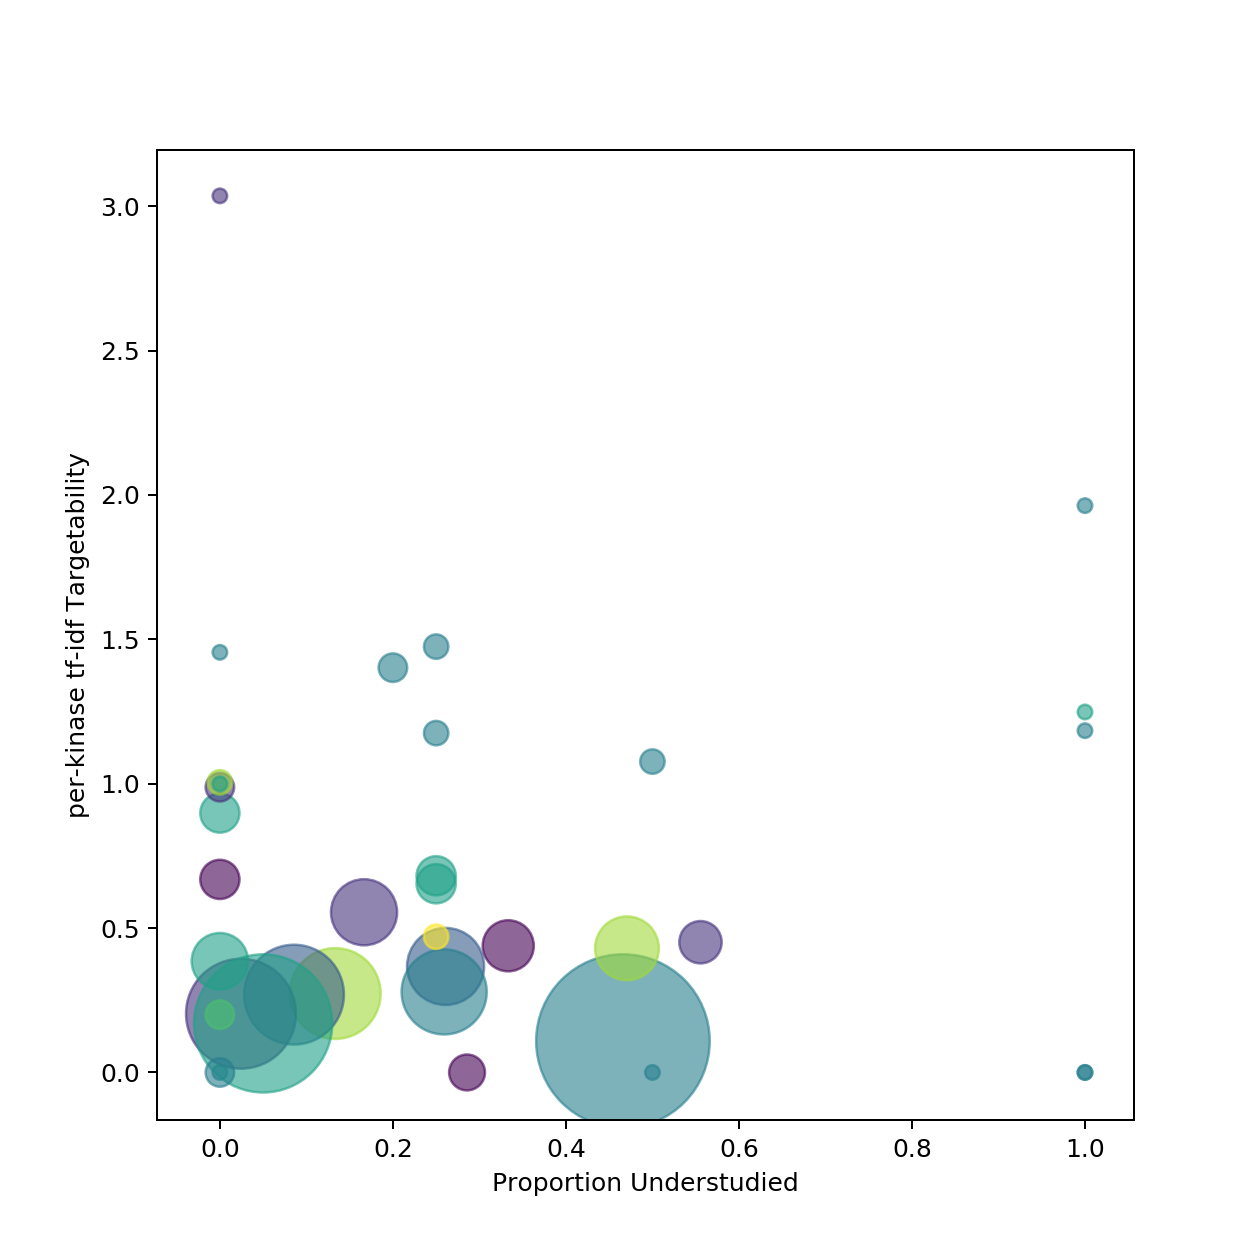

In [58]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7,7))
plt.scatter(x=subcluster_data['understudied']/subcluster_data['names'], y=subcluster_data['drug_score']/subcluster_data['names'], s=subcluster_data['names'].apply(lambda x: (np.log(x)+1)*x*10), c=subcluster_data['cluster_super'], alpha=.6)
plt.xlabel('Proportion Understudied')
plt.ylabel('per-kinase tf-idf Targetability')
#ax.set_yscale("log", basey=2)#, nonposy='clip')
#plt.ylim([-2,4])
plt.show()